In [1]:
import torch
from transformers import SegformerFeatureExtractor
import sys
sys.path.insert(1, '../utils/')
import os
import numpy as np

/home/emir/anaconda3/envs/emirenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from create_dataloaders import EddyDatasetTrain, EddyDatasetValid

In [3]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 128

/home/emir/anaconda3/envs/emirenv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [4]:
input_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/aug_data/"
mask_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/aug_label/"
val_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/data/"
val_mask_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/label/"

In [5]:
train_len = len(os.listdir(input_image_dir))
split = int(0.85 * train_len)

In [6]:
train_data = EddyDatasetTrain(feature_extractor=feature_extractor, input_image_dir=input_image_dir, mask_image_dir=mask_image_dir, split=split)
valid_data = EddyDatasetValid(feature_extractor=feature_extractor, input_image_dir=val_image_dir, mask_image_dir=val_mask_dir, split=split)

In [7]:
len(train_data), len(valid_data)

(9180, 1620)

In [8]:
import matplotlib.pyplot as plt

In [9]:
def visualize_train_data(data):
    rand_ind = np.random.randint(len(train_data))
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow((data[rand_ind]['pixel_values']).permute(1,2,0))
    plt.axis(False)
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow((data[rand_ind]['labels']))
    plt.axis(False)
    plt.title("Label")


In [10]:
train_data[0]['labels'].shape

torch.Size([128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


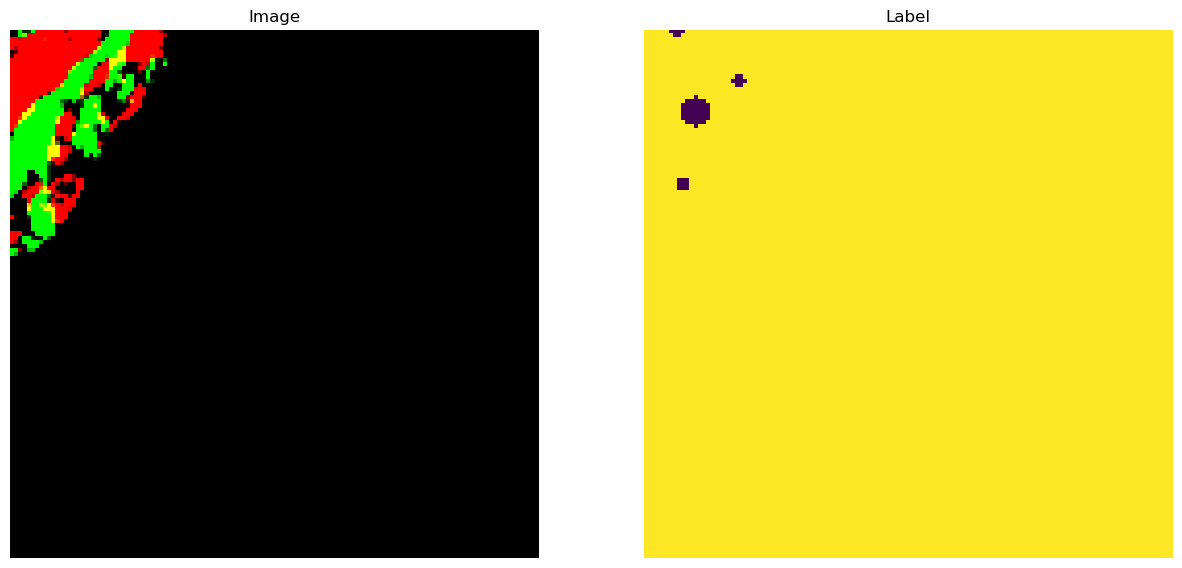

In [11]:
visualize_train_data(train_data)

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [13]:
len(train_dataloader)

287

In [14]:
feature_extractor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": 128
}

In [15]:
pretrained_weights = "nvidia/segformer-b0-finetuned-ade-512-512"

In [16]:
import pytorch_lightning as pl
from datasets import load_metric
import torch
from torch import nn

In [17]:
from transformers import SegformerForSemanticSegmentation

In [20]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type='dataset')), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Downloading: 100%|██████████| 2.81k/2.81k [00:00<00:00, 1.57MB/s]
Downloading: 100%|██████████| 70.0k/70.0k [00:00<00:00, 272kB/s] 
Downloading: 100%|██████████| 14.4M/14.4M [00:01<00:00, 8.04MB/s]
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['

In [26]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate((train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric._compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False,
                                   references=labels.cpu().numpy(),
                                   predictions=predicted.cpu().numpy()
                                    # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

cuda
Epoch: 0


/home/emir/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/emir/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 4.839908599853516
Mean_iou: 0.00016161606263116767
Mean accuracy: 0.010349990056633326
Loss: 3.197761297225952
Mean_iou: 0.0557980590470053
Mean accuracy: 0.7792054167205551
Loss: 1.9932997226715088
Mean_iou: 0.2858375564808675
Mean accuracy: 0.6705571411845552
Epoch: 1
Loss: 1.2289550304412842
Mean_iou: 0.5323069789218681
Mean accuracy: 0.5417970521630587
Loss: 0.6507930755615234
Mean_iou: 0.6164517145194925
Mean accuracy: 0.6293937027152363
Loss: 0.33203214406967163
Mean_iou: 0.5189236989339944
Mean accuracy: 0.5268034351976031
Epoch: 2
Loss: 0.2615724205970764
Mean_iou: 0.6318491863519304
Mean accuracy: 0.657173971400869
Loss: 0.14938677847385406
Mean_iou: 0.5810744545511276
Mean accuracy: 0.5941196178196315
Loss: 0.13393421471118927
Mean_iou: 0.5929559184113665
Mean accuracy: 0.6110315522523162
Epoch: 3
Loss: 0.10107080638408661
Mean_iou: 0.5488479123697381
Mean accuracy: 0.5559729391894487
Loss: 0.10176530480384827
Mean_iou: 0.6012496618679041
Mean accuracy: 0.64085887873903